<a href="https://colab.research.google.com/github/XanimGuliyeva/Add_to_basket/blob/main/1_Project_QA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Presentation Plan: Extractive Question Answering Using BERT, BM25, and DPR

In [ ]:
!pip install transformers datasets torch faiss-cpu rank_bm25 sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer

model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

    start_positions, end_positions = [], []

    for i in range(len(examples["question"])):
        answer = examples["answers"][i]

        if answer["answer_start"] and answer["text"]:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])

            start_token = inputs.char_to_token(i, start_char) or 0
            end_token = inputs.char_to_token(i, end_char - 1) or 0
        else:
            start_token, end_token = 0, 0

        start_positions.append(start_token)
        end_positions.append(end_token)

    inputs.update({"start_positions": start_positions, "end_positions": end_positions})
    return inputs

encoded_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [ ]:
# Define dataset sizes
TRAIN_SIZE = 5000
VAL_SIZE = 2000  # Reduce validation size
TEST_SIZE = 800  # New test set

# Select subsets
small_train_dataset = encoded_dataset["train"].select(range(TRAIN_SIZE))
small_val_dataset = encoded_dataset["validation"].select(range(VAL_SIZE))
test_dataset = encoded_dataset["validation"].select(range(VAL_SIZE, VAL_SIZE + TEST_SIZE))

print(f"Train Samples: {len(small_train_dataset)}")
print(f"Validation Samples: {len(small_val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")


Train Samples: 5000
Validation Samples: 2000
Test Samples: 800


In [ ]:
print(dataset["train"].column_names)

['id', 'title', 'context', 'question', 'answers']


In [ ]:
print(encoded_dataset["train"].column_names)

['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions']


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers.trainer_callback import ProgressCallback
from transformers import EarlyStoppingCallback

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_total_limit=2,
    remove_unused_columns=False,
    logging_dir='./logs',
    logging_steps=50,

    logging_strategy="steps",
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.001,
    max_grad_norm=1.0,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-3a241af8ab6c>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xanimguliyeva1 (xanimguliyeva1-siena-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.663500,0.405552
2,0.573400,0.359338
3,0.387000,0.407266


TrainOutput(global_step=1875, training_loss=0.7591445556640625, metrics={'train_runtime': 553.9557, 'train_samples_per_second': 27.078, 'train_steps_per_second': 3.385, 'total_flos': 3919451351040000.0, 'train_loss': 0.7591445556640625, 'epoch': 3.0})

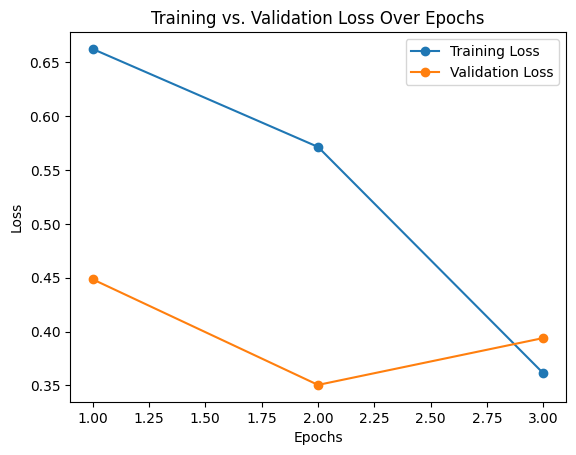

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_loss = [0.662400, 0.571400, 0.361100]
val_loss = [0.448554, 0.350456, 0.394026]

plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss Over Epochs")
plt.show()


In [ ]:
from transformers import pipeline

In [ ]:
# Save the trained model after training
trainer.save_model("./fine_tuned_bert")

# Load the fine-tuned model for inference
qa_pipeline = pipeline("question-answering", model="./fine_tuned_bert", tokenizer=tokenizer)

# Example Question & Context
context = "The Eiffel Tower is in Paris, France. It was built in 1889."
question = "Where is the Eiffel Tower?"

# Get prediction
result = qa_pipeline(question=question, context=context)

# Print the predicted answer
print(f"Predicted Answer: {result}")

Device set to use cuda:0


Predicted Answer: {'score': 2.6903195248451084e-05, 'start': 11, 'end': 16, 'answer': 'Tower'}


In [ ]:
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.2979544401168823, 'eval_runtime': 6.4575, 'eval_samples_per_second': 123.886, 'eval_steps_per_second': 15.486, 'epoch': 3.0}


In [ ]:
import torch
import faiss
import numpy as np
import nltk
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from transformers import DPRQuestionEncoder, DPRContextEncoder, DPRQuestionEncoderTokenizer, DPRContextEncoderTokenizer

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

# Sample documents for retrieval
documents = [
    "The Eiffel Tower is in Paris.",
    "The Statue of Liberty is in New York.",
    "Mount Everest is the highest mountain."
]

query = "Where is the Eiffel Tower?"


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
### === 1. BM25 Retrieval === ###
print("\n🔹 Using BM25")
tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]
bm25 = BM25Okapi(tokenized_docs)

query_tokens = word_tokenize(query.lower())
bm25_scores = bm25.get_scores(query_tokens)

best_bm25_index = np.argmax(bm25_scores)
best_bm25_match = documents[best_bm25_index]

print(f"✅ BM25 Best Match: {best_bm25_match}")
print(f"BM25 Scores: {bm25_scores}")


🔹 Using BM25
✅ BM25 Best Match: The Eiffel Tower is in Paris.
BM25 Scores: [ 1.05614593 -0.00633684 -0.00711103]


In [ ]:
# 🔥 Use BERT QA on BM25 retrieved document
bm25_result = qa_pipeline(question=query, context=best_bm25_match)
print(f"🤖 Extracted Answer (BM25): {bm25_result['answer']}")

🤖 Extracted Answer (BM25): Paris


In [ ]:
import faiss
import numpy as np

# Load Sentence Transformer DPR model
dpr_model = SentenceTransformer("facebook-dpr-ctx_encoder-single-nq-base")

# Encode documents and query
doc_embeddings = dpr_model.encode(documents, convert_to_numpy=True)
query_embedding = dpr_model.encode([query], convert_to_numpy=True)

# **Normalize embeddings for dot product retrieval**
faiss.normalize_L2(doc_embeddings)
faiss.normalize_L2(query_embedding)

# Use Inner Product Index (Instead of L2)
index = faiss.IndexFlatIP(doc_embeddings.shape[1])
index.add(doc_embeddings)

# Perform search to get similarity scores
D, I = index.search(query_embedding, k=len(documents))  # Retrieve all docs

# Since FAISS returns inner product similarity, we can directly use these as DPR scores
dpr_similarity_scores = D[0]  # Extract similarity scores for the query

# Print the results
print(f"Sentence Transformers DPR Similarity Scores: {dpr_similarity_scores}")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.91k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence Transformers DPR Similarity Scores: [0.7119875 0.5333925 0.5134904]


In [ ]:
# 🔥 Use BERT QA on DPR retrieved document
st_dpr_result = qa_pipeline(question=query, context=best_st_match)
print(f"🤖 Extracted Answer (Sentence Transformers DPR): {st_dpr_result['answer']}")

NameError: name 'best_st_match' is not defined

In [ ]:
### === 3. Facebook DPR Implementation === ###
print("\n🔹 Using Facebook DPR")

# Load Facebook DPR models & tokenizers
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

# Encode the query
question_inputs = question_tokenizer(query, return_tensors="pt")
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Encode documents
context_embeddings = []
for doc in documents:
    context_inputs = context_tokenizer(doc, return_tensors="pt")
    context_embedding = context_encoder(**context_inputs).pooler_output
    context_embeddings.append(context_embedding)

# Convert to NumPy and normalize
context_embeddings = torch.cat(context_embeddings).detach().numpy()
faiss.normalize_L2(context_embeddings)
faiss.normalize_L2(question_embedding)

# Compute similarity and retrieve best match
fb_scores = np.dot(question_embedding, context_embeddings.T).squeeze(0)
best_fb_index = np.argmax(fb_scores)
best_fb_match = documents[best_fb_index]

print(f"✅ Facebook DPR Best Match: {best_fb_match}")
print(f"Facebook DPR Similarity Scores: {fb_scores}")


🔹 Using Facebook DPR


config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


✅ Facebook DPR Best Match: The Eiffel Tower is in Paris.
Facebook DPR Similarity Scores: [0.68320775 0.5429776  0.51198417]


In [ ]:
# 🔥 Use BERT QA on Facebook DPR retrieved document
fb_dpr_result = qa_pipeline(question=query, context=best_fb_match)
print(f"🤖 Extracted Answer (Facebook DPR): {fb_dpr_result['answer']}")

🤖 Extracted Answer (Facebook DPR): Paris


In [ ]:
print("Raw BM25 Scores:", bm25_scores)
print("Raw ST-DPR Scores:", D.flatten())
print("Raw Facebook DPR Scores:", fb_scores)


Raw BM25 Scores: [ 1.05614593 -0.00633684 -0.00711103]
Raw ST-DPR Scores: [0.7119875 0.5333925 0.5134904]
Raw Facebook DPR Scores: [0.68320775 0.5429776  0.51198417]



🔹 Comparing Models
BM25: Match = 'The Eiffel Tower is in Paris.', Score = 1.0000
Sentence Transformers DPR: Match = 'The Eiffel Tower is in Paris.', Score = 1.0000
Facebook DPR: Match = 'The Eiffel Tower is in Paris.', Score = 1.0000

🏆 Best Model for Query: BM25 (Match: The Eiffel Tower is in Paris., Score: 1.0000)


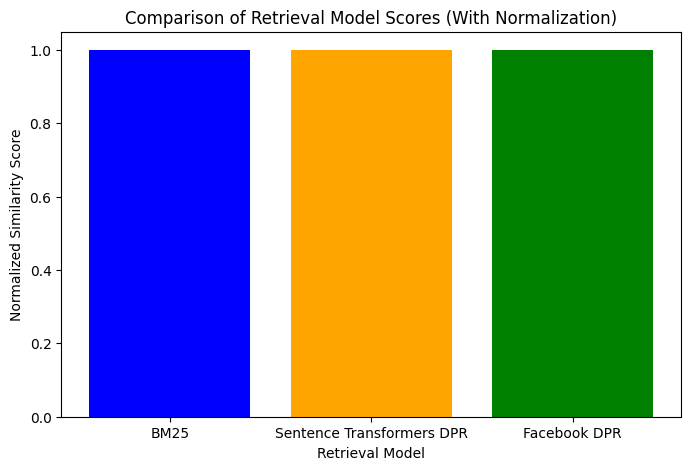

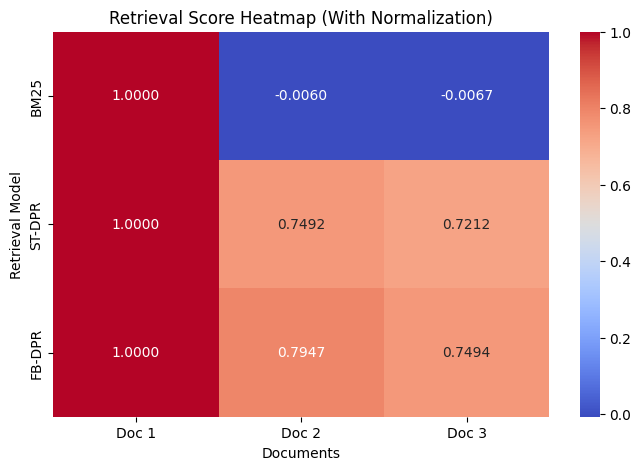

In [ ]:
### === 4. Compare Models === ###
print("\n🔹 Comparing Models")

# Ensure indices are correctly defined
best_bm25_index = np.argmax(bm25_scores)  # Get best BM25 document index
best_st_index = np.argmax(D.flatten())  # Get best Sentence Transformer document index
best_fb_index = np.argmax(fb_scores)  # Get best Facebook DPR document index

# Normalize all retrieval scores across all documents
bm25_normalized = bm25_scores / np.max(bm25_scores) if np.max(bm25_scores) != 0 else np.zeros_like(bm25_scores)
st_normalized = D.flatten() / np.max(D.flatten()) if np.max(D.flatten()) != 0 else np.zeros_like(D.flatten())
fb_normalized = fb_scores / np.max(fb_scores) if np.max(fb_scores) != 0 else np.zeros_like(fb_scores)

# Combine scores into a dictionary (using document references)
comparison = {
    "BM25": (documents[best_bm25_index], bm25_normalized[best_bm25_index]),
    "Sentence Transformers DPR": (documents[best_st_index], st_normalized[best_st_index]),
    "Facebook DPR": (documents[best_fb_index], fb_normalized[best_fb_index])
}

# Determine the best model based on normalized similarity score
best_model = max(comparison, key=lambda x: comparison[x][1])

# Display results
for model, (match, score) in comparison.items():
    print(f"{model}: Match = '{match}', Score = {score:.4f}")

print(f"\n🏆 Best Model for Query: {best_model} (Match: {comparison[best_model][0]}, Score: {comparison[best_model][1]:.4f})")




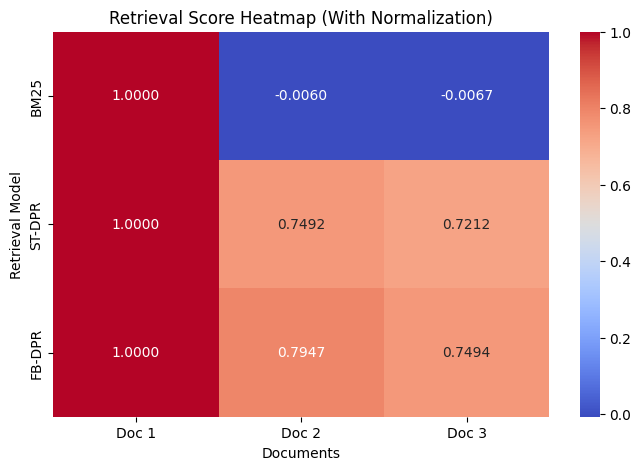

In [ ]:
### === 5. Visualization with Normalization === ###
import matplotlib.pyplot as plt
import seaborn as sns

# Define document labels
doc_labels = [f"Doc {i+1}" for i in range(len(documents))]

# Construct a heatmap using normalized scores across all documents
score_matrix = np.array([
    bm25_normalized,  # BM25 normalized scores for all documents
    st_normalized,    # ST-DPR normalized scores for all documents
    fb_normalized     # Facebook DPR normalized scores for all documents
])

plt.figure(figsize=(8, 5))
sns.heatmap(score_matrix, annot=True, xticklabels=doc_labels, yticklabels=["BM25", "ST-DPR", "FB-DPR"], cmap="coolwarm", fmt=".4f")
plt.xlabel("Documents")
plt.ylabel("Retrieval Model")
plt.title("Retrieval Score Heatmap (With Normalization)")
plt.show()